In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binom, beta
import pystan

In [3]:
df = pd.read_csv('baseball75.csv')
print(df.describe())
df.head()

         AB       Hits  RemainingAB  RemainingHits
count  18.0  18.000000    18.000000      18.000000
mean   45.0  11.944444   387.222222     108.444444
std     0.0   3.133730   161.010615      51.150553
min    45.0   7.000000    70.000000      14.000000
25%    45.0  10.000000   275.500000      64.000000
50%    45.0  11.000000   422.000000     127.000000
75%    45.0  14.000000   518.250000     140.750000
max    45.0  18.000000   591.000000     195.000000


,Player,AB,Hits,RemainingAB,RemainingHits
0,Clemente,45,18,367,127
1,Robinson,45,17,426,127
2,Howard,45,16,521,144
3,Johnstone,45,15,275,61
4,Berry,45,14,418,114


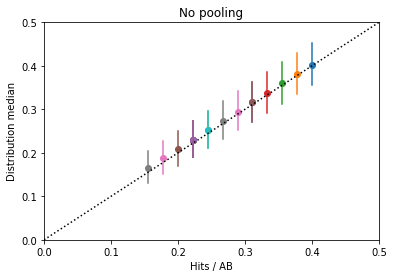

In [4]:
for p in df.values:
    a = 1 + p[2]
    b = 1 + p[1] - p[2]
    avg = p[2] / p[1]
    median = beta.median(a, b)
    quantiles = beta.ppf([0.25, 0.75], a, b)
    plt.plot([avg, avg], quantiles)
    plt.scatter(avg, median)
    plt.ylim(0, .5)
    plt.xlim(0, .5)
    plt.title('No pooling')
    plt.xlabel('Hits / AB')
    plt.ylabel('Distribution median')
    
plt.plot([0, 1], [0, 1], linestyle=':', color='black')
plt.show()

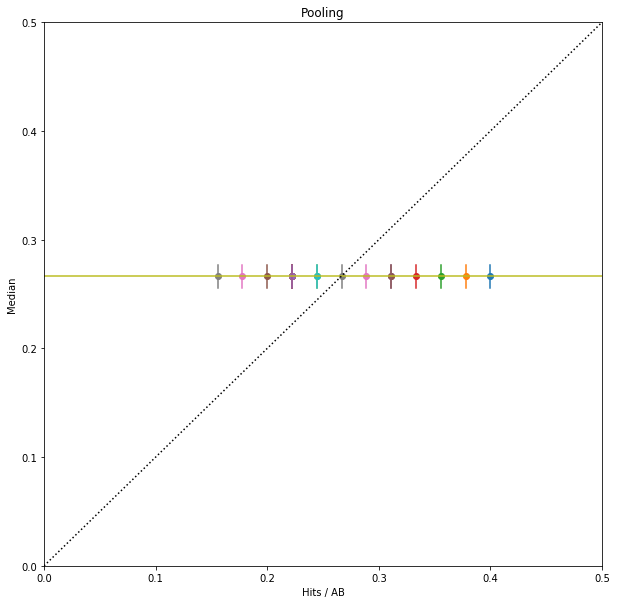

In [5]:
median = np.sum(df['Hits']) / len(df['Hits'])
a = np.sum(df['Hits']) + 1
b = np.sum(df['AB']) - a + 1
plt.figure(figsize=(10,10))

for p in df.values:
    avg = p[2] / p[1]
    quantiles = beta.ppf([0.25, 0.75], a, b)
    plt.plot([avg, avg], quantiles)
    median = beta.median(a, b)
    plt.scatter(avg, median)
    plt.ylim(0, .5)
    plt.xlim(0, .5)
    plt.title('Pooling')
    plt.xlabel('Hits / AB')
    plt.ylabel('Median')
    
plt.plot([0, 1], [median, median])
plt.plot([0, 1], [0, 1], linestyle=':', color='black')
plt.show()

In [6]:
stanball = """
data {
    int<lower=0> N;
    int<lower=0> AB[N];
    int<lower=0> hits[N];
}

parameters {
    real<lower=0, upper=1> phi;
    real<lower=0.1> lambda;
    real<lower=0, upper=1> theta[N];
}

transformed parameters {
    real<lower=0> a = lambda * phi;
    real<lower=0> b = lambda * ( 1 - phi ); 
}

model {
    hits ~ binomial(AB, theta);
    lambda ~ pareto(0.1, 1.5);
    theta ~ beta(a, b);
}
"""

data = {
    'N': 18,
    'AB': df['AB'],
    'hits': df['Hits']
}

sm = pystan.StanModel(model_code=stanball)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6111e06c117ac8b2b923992f8877b662 NOW.


In [7]:
fit = sm.sampling(data=data, iter=10000, chains=4, control={'adapt_delta':.99, 'stepsize':0.01})

In [8]:
extraction = fit.extract()
thetas = extraction['theta']

In [9]:
ms = np.median(thetas, axis=0)
qs = np.quantile(thetas, [0.25, 0.75], axis=0)

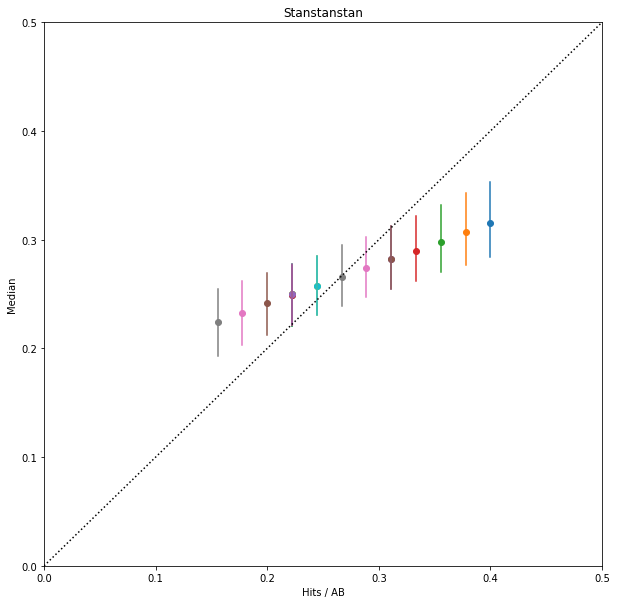

In [10]:
plt.figure(figsize=(10,10))

for ind, p in enumerate(df.values):
    avg = p[2] / p[1]
    quantiles = qs[:, ind]
    plt.plot([avg, avg], quantiles)
    median = ms[ind]
    plt.scatter(avg, median)
    plt.ylim(0, .5)
    plt.xlim(0, .5)
    plt.title('Stanstanstan')
    plt.xlabel('Hits / AB')
    plt.ylabel('Median')
plt.plot([0, 1], [0, 1], linestyle=':', color='black')
plt.show()

In [11]:
stanball_second_coming = """
data {
    int<lower=0> N;
    int<lower=0> AB[N];
    int<lower=0> hits[N];
}

parameters {
    real<lower=0> sigma;
    real mu;
    real a[N];
}

transformed parameters {
    real<lower=0, upper=1> theta[N] = inv_logit(a);
}

model {
    sigma ~ normal(0, 1);
    mu ~ normal(-1, 1);
    a ~ normal(mu, sigma);
    hits ~ binomial_logit(AB, a);
}
"""

data = {
    'N': 18,
    'AB': df['AB'],
    'hits': df['Hits']
}

sm = pystan.StanModel(model_code=stanball_second_coming)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cb1834aac79620a79ddde11d7696beb9 NOW.


In [12]:
fit2 = sm.sampling(data=data, iter=10000, chains=4, control={'adapt_delta':.99, 'stepsize':0.01})

In [13]:
extraction2 = fit2.extract()
thetas2 = extraction2['theta']

In [14]:
ms2 = np.median(thetas2, axis=0)
qs2 = np.quantile(thetas2, [0.25, 0.75], axis=0)

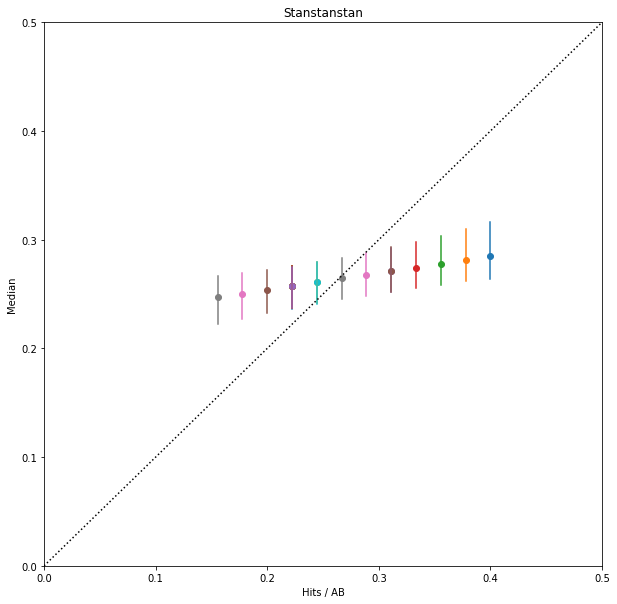

In [15]:
plt.figure(figsize=(10,10))

for ind, p in enumerate(df.values):
    avg = p[2] / p[1]
    quantiles = qs2[:, ind]
    plt.plot([avg, avg], quantiles)
    median = ms2[ind]
    plt.scatter(avg, median)
    plt.ylim(0, .5)
    plt.xlim(0, .5)
    plt.title('Stanstanstan')
    plt.xlabel('Hits / AB')
    plt.ylabel('Median')
plt.plot([0, 1], [0, 1], linestyle=':', color='black')
plt.show()

In [16]:
def simulator(theta, rem):
    res = np.zeros(theta.shape)
    for i in range(theta.shape[1]):
        ts = theta[:, i]
        player = [binom.rvs(rem[i], t, size=10).mean() / rem[i] for t in ts]
        res[:, i] = player
        
    return res

In [17]:
sims2 = simulator(thetas2, df['RemainingAB'])

In [21]:
sims = simulator(thetas, df['RemainingAB'])

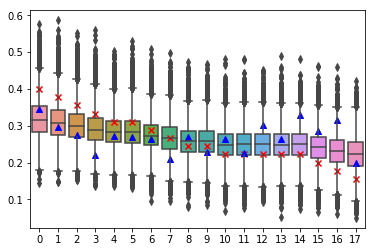

In [24]:
sns.boxplot(data=sims)
avgs = df['Hits'] / df['AB']

plt.scatter(range(18), avgs, marker='x', color='red')
plt.scatter(range(18), df['RemainingHits'] / df['RemainingAB'], marker='^', color='blue')


plt.show()

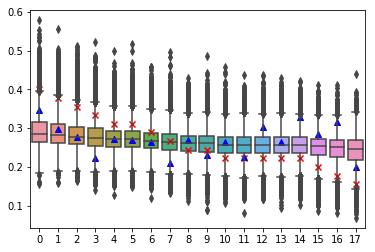

In [25]:
sns.boxplot(data=sims2)

plt.scatter(range(18), avgs, marker='x', color='red')
plt.scatter(range(18), df['RemainingHits'] / df['RemainingAB'], marker='^', color='blue')
plt.show()

In [39]:
def simulator2(theta, hits, rem):
    res = np.zeros(theta.shape)
    for i in range(theta.shape[1]):
        ts = theta[:, i]
        player = [binom.pmf(hits[i], rem[i], t) for t in ts]
        res[:, i] = player
        
    return res

In [ ]:
sims3 = simulator2(thetas, df['RemainingHits'], df['RemainingAB'])
sims4 = simulator2(thetas2, df['RemainingHits'], df['RemainingAB'])

In [44]:
np.sum(np.log(np.mean(sims3, axis=0)))

-73.95291169832484

In [ ]:
np.sum(np.log(np.mean(sims4, axis=0)))